In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive/')
sys.path.append('/content/drive/MyDrive/TradeCosts')

Mounted at /content/drive/


In [2]:
import Data_generator as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import datetime
import math, random
import matplotlib.pyplot as plt
import Utility_Loss as UL
import Func_One_Asset as FOA
import NN_One_Asset as NOA
import Plot_One_Asset as POA
import matplotlib.ticker as mticker
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# initialize seed, mu, sigma, S0, paths, steps, T and other data
seed_train = 33
seed_test = 37
npaths = 28000
seq_length = 120
T=10
s0=5
mu = 0.2
sigma = 0.5
#trading_cost= 0.01
gamma = 3.000
dt = T/seq_length
n_epochs = 100
learning_rate = 0.01
is_importance = False
trading_cost_vec = [0.0025,0.005,0.01,0.025,0.05]

In [4]:
ESR_simulated_vec = np.zeros(len(trading_cost_vec))
CI_upper_vec = np.zeros(len(trading_cost_vec))
CI_lower_vec = np.zeros(len(trading_cost_vec))
ESR_theo_vec = np.zeros(len(trading_cost_vec))
ESR_opt_vec = np.zeros(len(trading_cost_vec))

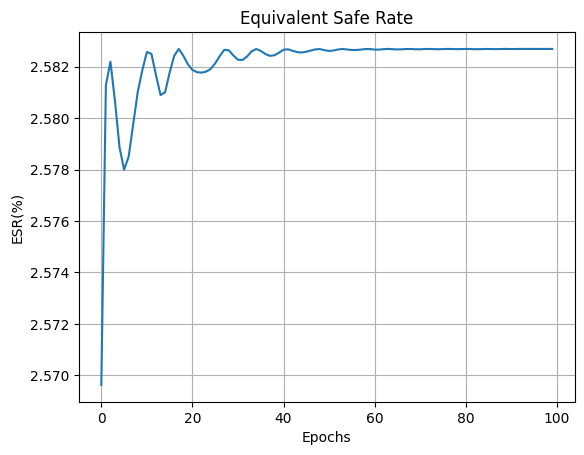

rnn.input_param.weight tensor([[0.]])
rnn.hidden_param.weight tensor([[1.]])
rnn.hidden_param.bias tensor([[0.0217]])
rnn.fc1_param.weight tensor([[-1.]])
rnn.fc1_param.bias tensor([[0.]])
rnn.fc2_param.weight tensor([[-1.]])
out.weight tensor([[1.]])


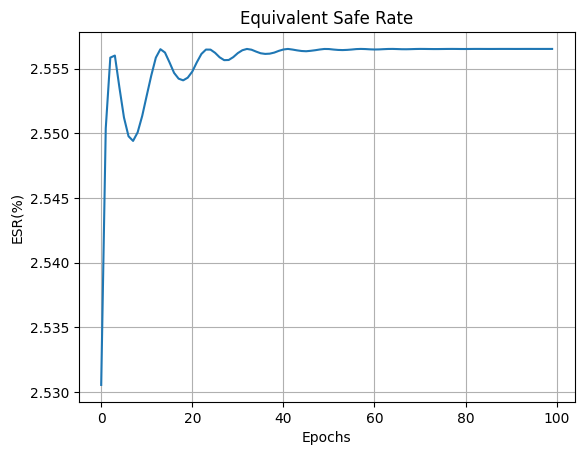

rnn.input_param.weight tensor([[0.]])
rnn.hidden_param.weight tensor([[1.]])
rnn.hidden_param.bias tensor([[0.0326]])
rnn.fc1_param.weight tensor([[-1.]])
rnn.fc1_param.bias tensor([[0.]])
rnn.fc2_param.weight tensor([[-1.]])
out.weight tensor([[1.]])


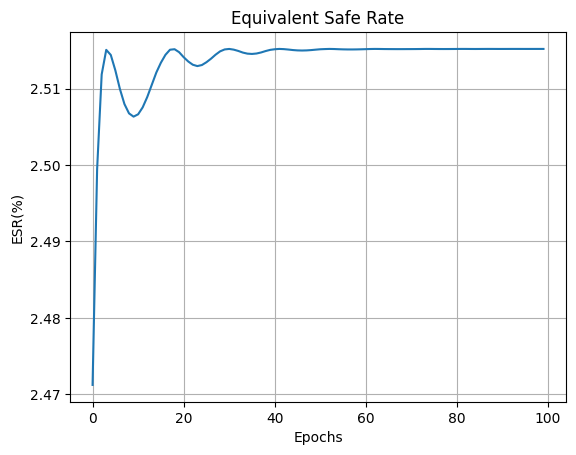

rnn.input_param.weight tensor([[0.]])
rnn.hidden_param.weight tensor([[1.]])
rnn.hidden_param.bias tensor([[0.0449]])
rnn.fc1_param.weight tensor([[-1.]])
rnn.fc1_param.bias tensor([[0.]])
rnn.fc2_param.weight tensor([[-1.]])
out.weight tensor([[1.]])


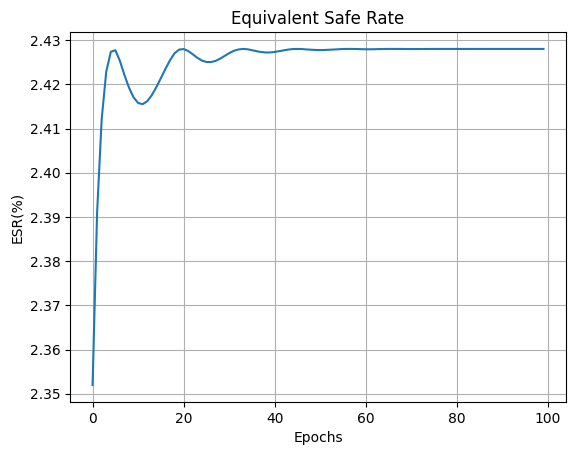

rnn.input_param.weight tensor([[0.]])
rnn.hidden_param.weight tensor([[1.]])
rnn.hidden_param.bias tensor([[0.0695]])
rnn.fc1_param.weight tensor([[-1.]])
rnn.fc1_param.bias tensor([[0.]])
rnn.fc2_param.weight tensor([[-1.]])
out.weight tensor([[1.]])


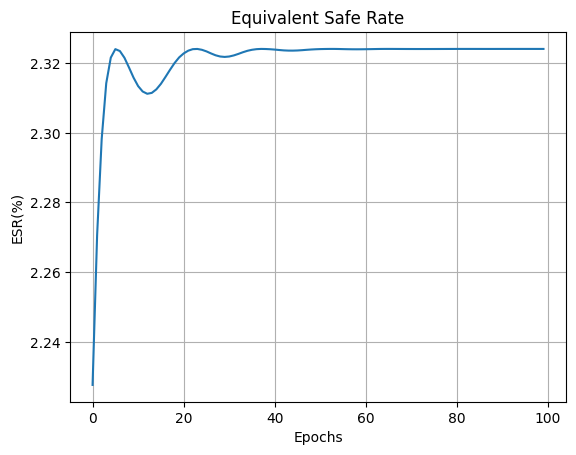

rnn.input_param.weight tensor([[0.]])
rnn.hidden_param.weight tensor([[1.]])
rnn.hidden_param.bias tensor([[0.0922]])
rnn.fc1_param.weight tensor([[-1.]])
rnn.fc1_param.bias tensor([[0.]])
rnn.fc2_param.weight tensor([[-1.]])
out.weight tensor([[1.]])


In [5]:
for i, trading_cost in enumerate(trading_cost_vec):

# Set portfolio
    returns, strategy, cost, Merton_opt, delta = FOA.make_portfolio(seed_train,mu,sigma,s0,npaths,seq_length,T,trading_cost,gamma)
# importance sampling
    returns, scaler = FOA.importance_sampling(is_importance,seed_train,mu,sigma,s0,npaths,seq_length,gamma,T)
# Set up model parameters, using paths as bath size, might not be the best, will try to fix later
    model, criterion, optimizer = FOA.make_model(1,1,1,npaths,seq_length, delta, gamma, learning_rate)
    model, losses = FOA.train_model(strategy.view(seq_length,1,1), Merton_opt, returns, cost, scaler, model, criterion, optimizer,n_epochs,gamma,T)
    returns, strategy, cost, Merton_opt, delta = FOA.make_portfolio(seed_test,mu,sigma,s0,npaths,seq_length,T,trading_cost,gamma)
    fina_strat, outputs = model(strategy.view(seq_length,1,1).double(), Merton_opt, returns, cost, None)
    ESR_simulated, CI, ESR_opt, ESR_theo = FOA.ESR(mu,sigma,gamma,outputs.detach().cpu().numpy(), T,trading_cost)
    ESR_simulated_vec[i] = ESR_simulated
    CI_upper_vec[i] = CI[0]
    CI_lower_vec[i] = CI[1]
    ESR_theo_vec[i] = ESR_theo
    ESR_opt_vec[i] = ESR_opt
    # After training is complete, clear memory by doing the following:
    # Delete model and optimizer
    del optimizer

    # Empty the CUDA cache
    torch.cuda.empty_cache()


/content/drive/MyDrive/TradeCosts/Plot_One_Asset.py:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  Cmean, = ax.plot(x, simulated, 'k--',color='blue')


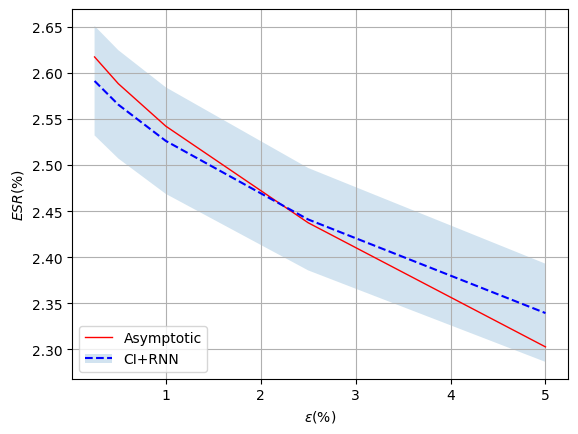

In [6]:
POA.plot_esr(np.array(trading_cost_vec),ESR_theo_vec,CI_lower_vec,CI_upper_vec,ESR_simulated_vec)

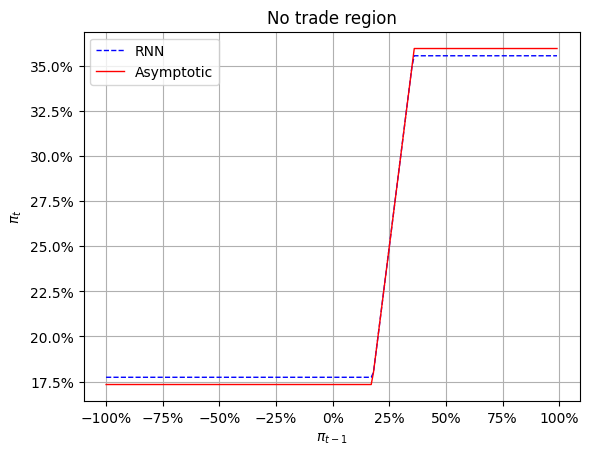

In [ ]:
POA.plot_ntr(model,-1,1,Merton_opt,trading_cost,gamma,delta)